In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [97]:
class MSHEContrastEnhancement:
    def __init__(self, image, num_intervals=2):
        self.image = image
        self.num_intervals = num_intervals

    def linear_stretching(self, img):
        """
        Step 1: Linear Stretching
        ! Paper Reference: Eq. (14)
        """
        
        img_min, img_max = img.min(), img.max()
        stretched = ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)  # Adjusting to [0, 255]
        return stretched

    def calculate_cp(self, img):
        """
        Calculate the central point (Cp) using cumulative frequency sum
        ! Paper Reference: Eq. (17)
        """
       
        hist, bins = np.histogram(img, bins=256, range=(0, 255))
        total_pixels = hist.sum()
        Fs = 0  # Initialize cumulative frequency sum
        for i, freq in enumerate(hist):
            Fs += freq
            if Fs >= 0.25 * total_pixels:  # Assuming lower quantile (25%)
                return bins[i]  # Return pixel value corresponding to Cp
        return bins[-1]  # Default to max value if not found

    def divide_histogram(self, img):
        """
        Step 2: Interval Division Threshold Selection
        ! Paper Reference: Eq. (18), (19), and handling of odd/even cases
        """
        
        Cp = self.calculate_cp(img)  # Calculate central point using Eq. (17)
        thresholds = []

        if self.num_intervals == 2:
            # Special Case: N_i = 2
            thresholds = [0, Cp, 255]
        elif self.num_intervals % 2 == 0:
            # Even intervals: Include Cp as a threshold
            num_intervals_half = self.num_intervals // 2
            # Generate thresholds to the left of Cp
            thresholds += [Cp - i for i in range(0, int(Cp), int(Cp / num_intervals_half))]
            # Generate thresholds to the right of Cp
            thresholds += [Cp + i for i in range(0, 256 - int(Cp), int((256 - Cp) / num_intervals_half))]
            thresholds = sorted(set([0] + thresholds + [255]))
        else:
            # Odd intervals: Exclude Cp as a threshold
            num_intervals_half = (self.num_intervals - 1) // 2
            # Generate thresholds to the left of Cp
            thresholds += [Cp - i for i in range(0, int(Cp), int(Cp / num_intervals_half))]
            # Generate thresholds to the right of Cp
            thresholds += [Cp + i for i in range(0, 256 - int(Cp), int((256 - Cp) / num_intervals_half))]
            thresholds = sorted(set([0] + thresholds + [255]))
            # Ensure Cp is only used for calculation and not as a threshold
            thresholds.remove(Cp)

        subhistograms = [(img >= thresholds[i]) & (img <= thresholds[i + 1]) for i in range(len(thresholds) - 1)]
        return subhistograms, thresholds

    def equalize_subhistogram(self, img, mask, min_val, max_val):
        """
        Step 3: Subhistogram Equalization using Eq. (29)
        ! Paper Reference: Eq. (29)
        """
        sub_img = img[mask]
        if len(sub_img) > 1:
            hist, bins = np.histogram(sub_img, bins=256, range=(min_val, max_val))
            cdf = hist.cumsum()
            cdf = cdf / cdf[-1]  # Normalized CDF
            
            # ! Apply Eq. (29)
            d_a = min_val
            d_a1 = max_val
            transformed_values = d_a + 1 + ((d_a1 - d_a - 1) * cdf)
            
            # Map the original pixel values to transformed values
            img[mask] = np.interp(sub_img, bins[:-1], transformed_values).astype(np.uint8)
        return img

    def enhance_contrast(self):
        """
        Apply MSHE Contrast Enhancement
        """
        stretched_img = self.linear_stretching(self.image)
        subhistograms, thresholds = self.divide_histogram(stretched_img)

        for i, mask in enumerate(subhistograms):
            stretched_img = self.equalize_subhistogram(stretched_img, mask, thresholds[i], thresholds[i + 1])

        return stretched_img


In [98]:
"""
    Make sure to have the following directory structure:
    turbid-image-enhancement
    ├── data
    |   ├── dataset
    |   |   ├── train
    |   |   |   ├── all the directories containing images
    
    ! Make sure to have this, or else you need to change the code accordingly
"""

class UnderwaterImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(subdir, file)
            for subdir, _, files in os.walk(root_dir)
            for file in files if file.endswith(('png', 'jpg', 'jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [99]:
def show_images(original, enhanced):
    """
    Display original and enhanced images side by side.
    """
    fig, axs = plt.subplots(2, len(original), figsize=(12, 6))
    for i in range(len(original)):
        axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title("Original")

        axs[1, i].imshow(enhanced[i], cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title("Enhanced")

    plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = UnderwaterImageDataset(root_dir='../data/dataset/train', transform=transform)  # Adjust path as needed
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)


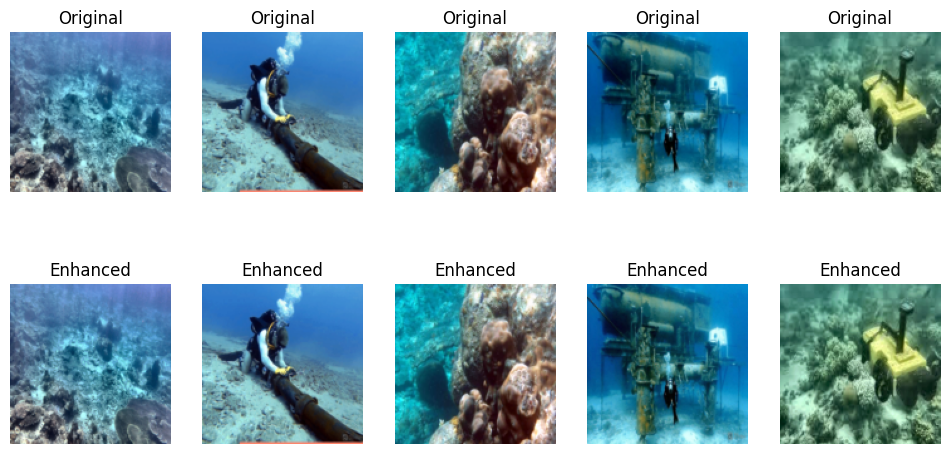

In [ ]:
data_iter = iter(dataloader)
images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=10)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)